# Generate Log for Maintenance Activitiy based on WROMY LightSensors

Use the light sensors of WROMY to identify maintenance activity and plot them as calendar plots 

In [22]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import calplot

from pathlib import Path

In [23]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/bay200/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'
elif os.uname().nodename == 'lin-ffb-01':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'

### Configurations

In [63]:
config = {}

config['threshold'] = 5 ## light threshold to classify as <light on> / <light off>

config['path_to_LX_data'] = archive_path+"romy_archive/"

config['start_date'] = '01/01/2024' ## MM/DD/YYYY
config['end_date']   = '12/31/2024' ## MM/DD/YYYY

config['year'] = config['start_date'][-4:]

config['path_to_outdata'] = archive_path+f"wromy_files/{config['year']}_maintenance_lx_sensors.csv"

config['path_to_figs'] = archive_path+f"romy_plots/{config['year']}/logs/"


In [64]:
def __update_maintenance_protocoll(config):

    ## make new output file with header
    with open(config['path_to_outdata'], mode="w") as f:
        f.write("Sensor,Timestamp,Date,Time,State\n")

    ## iterate for dates
    for date in pd.date_range(start=config['start_date'], end=config['end_date']):

        fdate = str(date)[:10].replace("-", "")

        ## interate for all sensors of WROMY
        for sensor in [1,4,5,6,7,8,9]:

            filename = f'WS{sensor}_{fdate}.txt'
            datapath = f'/import/freenas-ffb-01-data/romy_archive/{date.year}/BW/WROMY/LX{sensor}.D/'

            ## read file
            if Path(datapath+filename).exists():
                df = pd.read_csv(datapath+filename, names=['Date', 'Time', 'State'])
            else:
                print(f" -> {datapath+filename} does not exists!")
                continue

            ## smooth the light sensor data
            df['smoothed'] = df['State'].rolling(10, center=True).mean()

            ## apply threshold
            df['smoothed'] = df['smoothed'].where(df.smoothed > config['threshold']).fillna(0)
            df['smoothed'] = df['smoothed'].clip(lower=None, upper=config['threshold'])

            ## calculate differences for picking
            df['State'] = df.smoothed.diff()/config['threshold']

            ## get start and end points of light period
            select = df.where(abs(df.State) > 0).dropna()

            ## modify data
            select.drop(columns=["smoothed"], inplace=True)
            select = select.astype(int)
            select['State'] = select['State'].replace(-1, 0)

            ## format and write to output file
            with open(config['path_to_outdata'], mode="a") as f:
                for idx, row in select.iterrows():
                    dd = str(row.Date)
                    tt = str(row.Time).zfill(6)
                    ts = f"{dd[:4]}-{dd[4:6]}-{dd[6:8]}T{tt[:2]}:{tt[2:4]}:{tt[4:6]}"
                    f.write(f"WS{sensor},{ts},{row.Date},{row.Time},{row.State}\n");

In [65]:
__update_maintenance_protocoll(config)

 -> /import/freenas-ffb-01-data/romy_archive/2024/BW/WROMY/LX1.D/WS1_20240228.txt does not exists!
 -> /import/freenas-ffb-01-data/romy_archive/2024/BW/WROMY/LX4.D/WS4_20240228.txt does not exists!
 -> /import/freenas-ffb-01-data/romy_archive/2024/BW/WROMY/LX5.D/WS5_20240228.txt does not exists!
 -> /import/freenas-ffb-01-data/romy_archive/2024/BW/WROMY/LX6.D/WS6_20240228.txt does not exists!
 -> /import/freenas-ffb-01-data/romy_archive/2024/BW/WROMY/LX7.D/WS7_20240228.txt does not exists!
 -> /import/freenas-ffb-01-data/romy_archive/2024/BW/WROMY/LX8.D/WS8_20240228.txt does not exists!
 -> /import/freenas-ffb-01-data/romy_archive/2024/BW/WROMY/LX9.D/WS9_20240228.txt does not exists!
 -> /import/freenas-ffb-01-data/romy_archive/2024/BW/WROMY/LX1.D/WS1_20240229.txt does not exists!
 -> /import/freenas-ffb-01-data/romy_archive/2024/BW/WROMY/LX4.D/WS4_20240229.txt does not exists!
 -> /import/freenas-ffb-01-data/romy_archive/2024/BW/WROMY/LX5.D/WS5_20240229.txt does not exists!
 -> /impor

### Make Calendar Plots

In [66]:
## load the compressed maintenance file
df = pd.read_csv(config['path_to_outdata'])

## convert to datetime objects
df['Timestamp'] = pd.to_datetime(df['Timestamp'].replace("T", " "))

## reset the index
df.set_index('Timestamp', inplace=True)

## group by dates and sum the states
df_compressed = df.groupby(['Date', 'Sensor'])['State'].sum().reset_index()

## count sensors
df_compressed['sensor_count'] = np.ones(len(df_compressed))
df_compressed = df_compressed.groupby(['Date'])['sensor_count'].sum().reset_index()
df_compressed['Date'] = pd.to_datetime(df_compressed['Date'].astype(str), format="%Y%m%d")

## reset the index
df_compressed.set_index('Date', inplace=True)


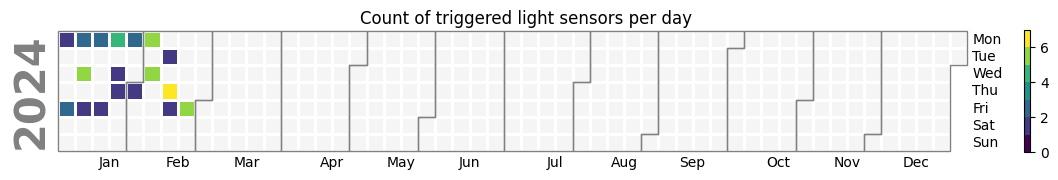

In [67]:

pl1 = calplot.calplot(data = df_compressed['sensor_count'],
                      how = 'sum',
                      cmap = plt.get_cmap('viridis', 7),
                      colorbar = True,
                      suptitle = "Count of triggered light sensors per day",
                      yearlabel_kws={'fontname':'sans-serif'},
                      vmin=0, vmax=7,
                     )

pl1[0].savefig(config['path_to_figs']+f"{config['year']}_LX_maintenance_overview.png", format="png", dpi=150, bbox_inches='tight')